In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
from tqdm import tqdm
import torch
sys.path.append('../')
from plane import Plane
from propagator import PropagatorFactory

from scipy.signal import fftconvolve
import torchvision

### CZT algorithm
The only change to allow for independent sampling of the input plane and the output plane is to replace the last calculation step $\mathbf{F}^{-1}\{U\}$ with a chirp z transform.

We need scaling factors $\alpha_x = \Delta x^z / \Delta {v_x}$, $\alpha_y = \Delta y^z / \Delta {v_y}$

We need new coordinates $w_x = \alpha_x v_x$, $w_y = \alpha_y v_y$

And therefore new sampling intervals $\Delta w_x = \Delta x = \alpha_x \Delta v_x$, $\Delta w_y = \Delta y = \alpha_y \Delta v_y$


The inverse fourier transform by the CZT is then

$$ u^z = \text{CZT}\{ U^z\} = \Delta w_x \Delta w_y C\left( \frac{U^z \cdot E}{\alpha_x \alpha_y} \circledast D \right) $$

where

$$ C = exp[j\pi(x^2/\alpha_x + y^2/\alpha_y)]$$

$$ D = exp[-j\pi(w_x^2/\alpha_x + w_y^2/\alpha_y)]$$

$$ E = exp[j\pi(w_x^2/\alpha_x + w_y^2/\alpha_y)]$$

and $\circledast$ is a linear convolution.

In [172]:
config = yaml.load(open('../config.yaml', 'r'), Loader=yaml.FullLoader)
plane1_params = {
    'name':'input_plane',
    'size': (5.e-3, 5.e-3),
    'Nx':512,
    'Ny':512,
    'center': (0,0,0),
    'normal': (0,0,1)
}
plane2_params = {
    'name':'output_plane',
    'size': (5.e-3, 5.e-3),
    'Nx':512,
    'Ny':512,
    'center': (0,0,9.e-2),
    'normal': (0,0,1)
}
plane3_params = {
    'name':'output_plane2',
    'size': (10e-3, 10e-3),
    'Nx':512,
    'Ny':512,
    'center': (0,0,9.e-2),
    'normal': (0,0,1)
}

plane1 = Plane(plane1_params)
plane2 = Plane(plane2_params)
plane3 = Plane(plane3_params)

2024-02-21 09:24:06.795 | DEBUG    | plane:__init__:8 - Initializing plane input_plane
2024-02-21 09:24:06.795 | DEBUG    | plane:fix_types:31 - Fixing types for plane input_plane
2024-02-21 09:24:06.796 | DEBUG    | plane:create_rotation_matrix:86 - Creating rotation matrix
2024-02-21 09:24:06.797 | DEBUG    | plane:create_rotation_matrix:99 - Input and output plane normals are the same.
2024-02-21 09:24:06.798 | DEBUG    | plane:build_plane:41 - Building plane input_plane
2024-02-21 09:24:06.799 | DEBUG    | plane:__init__:8 - Initializing plane output_plane
2024-02-21 09:24:06.799 | DEBUG    | plane:fix_types:31 - Fixing types for plane output_plane
2024-02-21 09:24:06.800 | DEBUG    | plane:create_rotation_matrix:86 - Creating rotation matrix
2024-02-21 09:24:06.801 | DEBUG    | plane:create_rotation_matrix:99 - Input and output plane normals are the same.
2024-02-21 09:24:06.802 | DEBUG    | plane:build_plane:41 - Building plane output_plane
2024-02-21 09:24:06.803 | DEBUG    | pl

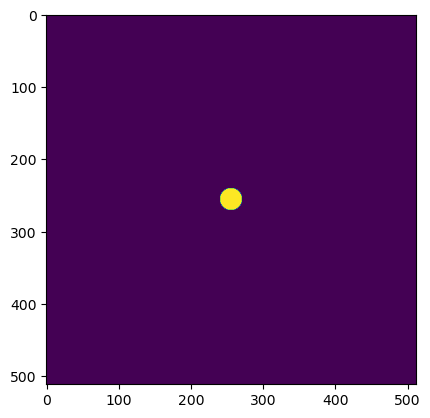

In [173]:
U = torch.ones((plane1.Nx, plane1.Ny))
mask = np.sqrt(plane1.xx**2 + plane1.yy**2) < 0.15e-3
U = U * mask
plt.imshow(U)

In [174]:
pf = PropagatorFactory()
config['propagator']['prop_type'] = None
prop = pf(plane1, plane2, config['propagator'])

2024-02-21 09:24:07.193 | DEBUG    | propagator:select_propagator:21 - Selecting propagator
2024-02-21 09:24:07.195 | DEBUG    | propagator:check_asm_distance:149 - Checking ASM propagation criteria
2024-02-21 09:24:07.195 | DEBUG    | propagator:check_asm_distance:162 - Axial distance between input and output planes: 0.09000000357627869
2024-02-21 09:24:07.196 | DEBUG    | propagator:check_asm_distance:171 - Maximum axial distance for asm : 0.06325050443410873
2024-02-21 09:24:07.197 | DEBUG    | propagator:select_propagator:86 - Using RSC propagator
2024-02-21 09:24:07.197 | DEBUG    | propagator:init_rsc_transfer_function:217 - Initializing RSC transfer function


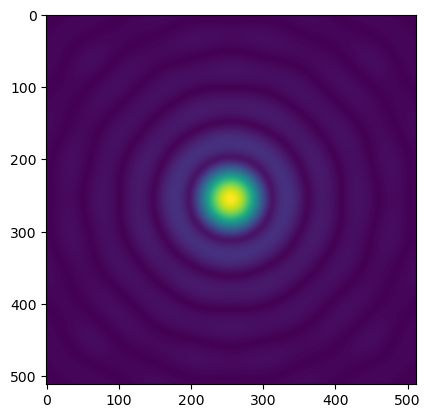

In [175]:
output = prop(U)
plt.imshow(output.abs())

In [176]:
#Double the size to eliminate rsc errors.
x = torch.linspace(-plane1.Lx/2 , plane1.Lx/2, plane1.Nx)
y = torch.linspace(-plane1.Ly/2 , plane1.Ly/2, plane1.Ny)
xx, yy = torch.meshgrid(x, y, indexing='ij')

# Get the fourier dimensions
fx = torch.fft.fftfreq(len(x), torch.diff(x)[0])
fy = torch.fft.fftfreq(len(y), torch.diff(y)[0])
fxx, fyy = torch.meshgrid(fx, fy, indexing='ij')

delta_vx = torch.diff(fx)[0]
delta_vy = torch.diff(fy)[0]

delta_xz = plane3.delta_x
delta_yz = plane3.delta_y

alpha_x = delta_xz / delta_vx
alpha_y = delta_yz / delta_vy

wx = alpha_x * fx
wy = alpha_y * fy

wxx, wyy = torch.meshgrid(wx,wy, indexing='ij')

delta_wx = torch.diff(wx)[0]
delta_wy = torch.diff(wy)[0]

print(delta_wx, plane3.delta_x)


distance = plane3.center[-1] - plane1.center[-1]
wavelength = 1.55e-6
r = torch.sqrt(xx**2 + yy**2 + distance**2)
k = (2 * torch.pi / wavelength)
z = distance.double()

h_rsc = torch.exp(1j*k*r) / r
h_rsc *= ((1/r) - (1j*k))
h_rsc *= (1/(2*torch.pi)) * (z/r)
H = torch.fft.fft2(h_rsc)
H = torch.fft.fftshift(H)
mag = H.abs()
ang = H.angle()
mag = mag / torch.max(mag)
H = mag * torch.exp(1j*ang)

tensor(1.9569e-05) tensor(1.9569e-05)


In [177]:
C = torch.exp(1j * torch.pi * ((plane3.xx**2 /alpha_x) + (plane3.yy**2 / alpha_y)))
D = torch.exp(-1j * torch.pi * ((xx**2 / alpha_x) + (yy**2 / alpha_y)))
E = torch.exp(1j * torch.pi * ((xx**2 / alpha_x) + (yy**2 / alpha_y)))

print(len(C), len(D), len(E))

512 512 512


In [178]:
print("alpha_x : {}".format(alpha_x))
print("alpha_y : {}".format(alpha_y))

print("delta_wx : {}".format(delta_wx))
print("delta_wy : {}".format(delta_wy))

print("delta_x : {}".format(plane1.delta_x))
print("delta_y : {}".format(plane1.delta_y))

print("delta_xz : {}".format(delta_xz))
print("delta_yz : {}".format(delta_yz))

print("len(wx) : {}".format(len(wx)))
print("len(wy) : {}".format(len(wy)))

print("len(C) : {}".format(len(C)))
print("len(D) : {}".format(len(D)))
print("len(E) : {}".format(len(E)))

print("delta_x1 / delta_xz : {}".format(plane1.delta_x / plane3.delta_x))
print("N * delta_x1**2 / alpha : {}".format(plane1.Nx * plane1.delta_x**2 / alpha_x))

alpha_x : 9.803828504573175e-08
alpha_y : 9.803828504573175e-08
delta_wx : 1.9569415599107742e-05
delta_wy : 1.9569415599107742e-05
delta_x : 9.784707799553871e-06
delta_y : 9.784707799553871e-06
delta_xz : 1.9569415599107742e-05
delta_yz : 1.9569415599107742e-05
len(wx) : 512
len(wy) : 512
len(C) : 512
len(D) : 512
len(E) : 512
delta_x1 / delta_xz : 0.5
N * delta_x1**2 / alpha : 0.4999999701976776


In [190]:
cc = torchvision.transforms.CenterCrop((len(C), len(C)))
padx = torch.div(plane1.Nx, 2, rounding_mode='trunc')
pady = torch.div(plane1.Ny, 2, rounding_mode='trunc')
padding = (pady,pady,padx,padx)   

U_padded = torch.nn.functional.pad(U,padding,mode="constant")

A = torch.fft.fft2(U)
A = torch.fft.fftshift(A)
Uz = A * H
Uz = (Uz * E) / (alpha_x * alpha_y)

D

Uz = fftconvolve(Uz, D, mode='full')
Uz = cc(torch.from_numpy(Uz)).numpy() * C.numpy() * delta_wx.numpy() * delta_wy.numpy()

In [189]:
cc = torchvision.transforms.CenterCrop((int(plane3.Nx), int(plane3.Ny)))

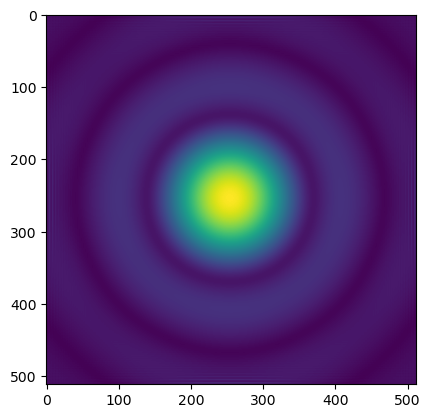

In [187]:
plt.imshow(np.abs(Uz))

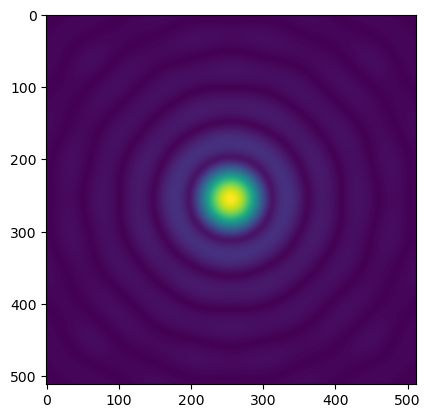

In [152]:
plt.imshow(output.abs())

In [12]:
len(C)

1024